In [370]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import math

In [371]:
def get_sorted_images(path):
    """Get sorted images by timestamp
    Args:
        path (str): path to images directory (image name example: aemet_ba_202201010000.gif)
    Returns:
        list: list of (timestamp, image_name) sorted by timestamp
    """

    images = os.listdir(path)
    timestamps = []
    for image in images:
        # get timestamp after last underscore
        date_time = image.split("_")[-1].split(".")[0]

        # convert date_time to timestamp
        timestamp = int(datetime.datetime.strptime(
            date_time, "%Y%m%d%H%M").timestamp())

        timestamps.append(timestamp)

    images = [(timestamp, name)
              for timestamp, name in sorted(zip(timestamps, images))]

    return images

In [377]:
val = cv2.cvtColor(cv2.imread("../data/gt/val.png"), cv2.COLOR_BGR2RGB)
barca = cv2.cvtColor(cv2.imread("../data/gt/palma.png"), cv2.COLOR_BGR2RGB)
# barca = cv2.cvtColor(cv2.imread("../data/gt/barca.png"), cv2.COLOR_BGR2RGB)

In [378]:
def groundtruth_map(image_sequences, name = "", save = False):
    """
    This function samples frames from the sequence of images and uses
    temporal median filter to create the background model. 
    Parameters:
        source (str): the path to the video file
        sampling_prob (float): probaility for each frame to be sampled
        save (bool): determines whether to save the baackground model as image
    Returns:
        np.ndarray: the background mask
    """
    # Background Model using median filter
    is_np = np.array(image_sequences)
    background_model = np.median(is_np, axis=0, keepdims=True).astype('uint8')
    if save:
        if name:
            cv2.imwrite(f"../data/{name}_background_model.png", background_model[0])
        else:
            cv2.imwrite(f"../data/background_model.png", background_model[0])
    return background_model[0] #cv2.cvtColor(, cv2.COLOR_BGR2RGB)

In [379]:
def get_foreground_mask(gt_mask, img, name, threshold = 0):
    foreground = cv2.cvtColor(cv2.absdiff(img, gt_mask), cv2.COLOR_RGB2GRAY)
    foreground[foreground > threshold] = 255
#     foreground[foreground<=threshold] = 0
    
#     cv2.imwrite(name + ".png", foreground)
    plt.imshow(foreground, cmap = "gray")
    return foreground

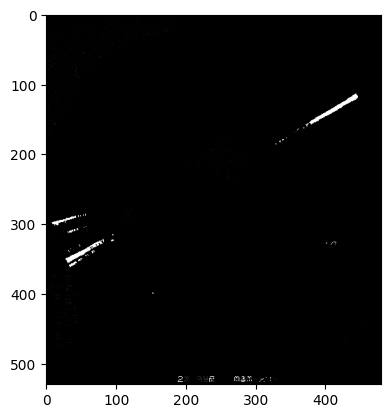

In [380]:
batch = 17
img_seq = []
for img_dir in os.listdir("./test")[:batch]:
    temp = np.array(Image.open(os.path.join('./test', img_dir)).convert("RGB"))
    #     blur = cv2.bilateralFilter(temp,18,75,75)
    #cv2.erode(blur, np.ones((3,3)))
    img_seq.append(temp)
img_ave = groundtruth_map(img_seq)
img_ave_mask = get_foreground_mask(barca, img_ave, "with_int" , threshold = 60)
# img_ave_mask = cv2.dilate(last_img_mask, np.ones((3,3)))

In [365]:
cv2.imwrite("average_mask.png", img_ave_mask)

True

True

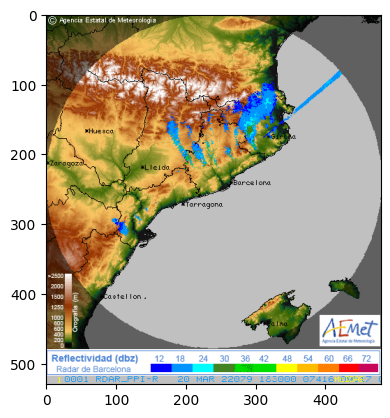

In [294]:
plt.imshow(img_ave)
cv2.imwrite("average.png", cv2.cvtColor(img_ave, cv2.COLOR_BGR2RGB))

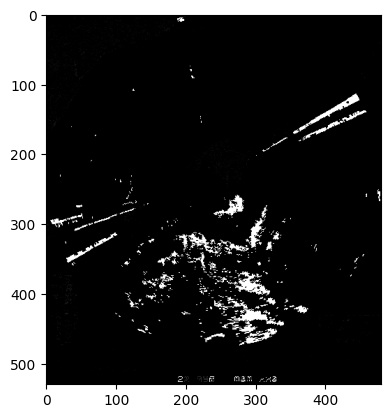

In [381]:
last_img = np.array(Image.open(os.path.join('./test', os.listdir("./test")[-1])).convert("RGB"))
last_img_mask = get_foreground_mask(barca, last_img, "with_int" , threshold = 60)

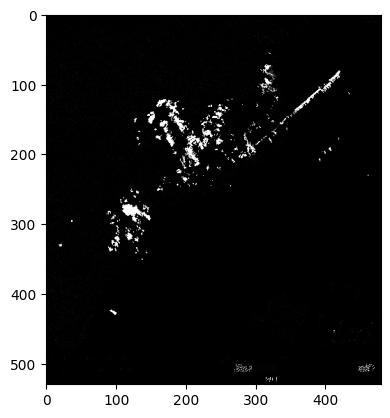

In [239]:
plt.imshow(cv2.bitwise_and(last_img_mask, cv2.bitwise_not(img_ave_mask)), 'gray')

In [390]:
def dataset_creator(gt, bg, img):
    res = gt.copy()
    for x in range(bg.shape[0]):
        for y in range(bg.shape[1]):
            if bg[x, y] != 0:
                res[x,y,:] = img[x,y,:]
        
#     plt.imshow(res)
#     out = cv2.bitwise_and(gt,gt,mask = res)
    return res

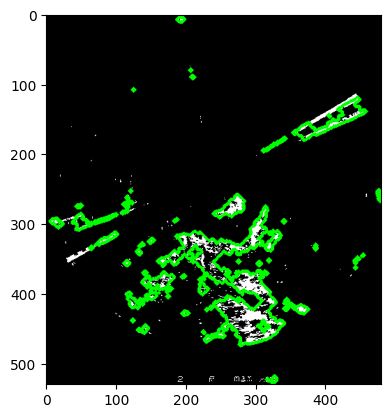

In [391]:
out_cnt = np.zeros_like(last_img_mask)
mask_bg = cv2.bitwise_and(last_img_mask, cv2.bitwise_not(img_ave_mask))#last_img_mask.copy()
mask_bg[mask_bg < 255] = 0
mask_bg = cv2.dilate(mask_bg, np.ones((3,3)))
mask_bg = cv2.morphologyEx(mask_bg, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)))
mask_bg = cv2.morphologyEx(mask_bg, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS,(15,15)))
contours,hierarchy = cv2.findContours(mask_bg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
out_cnt[last_img_mask == 255] = 255
# out_cnt = cv2.drawContours(out_cnt, contours, -1, (0,255,0), 3)
plt.imshow(out_cnt, 'gray')

In [384]:
for cnt in contours:
    score  = 0
    
    # crit 1:
    rows,cols = out_cnt.shape[:2]
    [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    ori = math.atan2((righty - lefty),(cols-1)) * 180 / np.pi
    c1_score = abs(abs(ori) - 45)
    
    # crit 2:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    (x, y), (width, height), angle = rect
    try:
        aspect_ratio = min(width, height) / max(width, height)
    except:
        continue
    if aspect_ratio < 0.2 or (aspect_ratio < 0.4 and c1_score < 5):
        cv2.drawContours(out_cnt,[box],-1,0,-1)

True

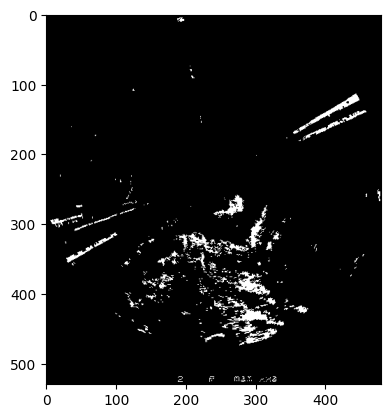

In [385]:
plt.imshow(out_cnt, 'gray')
cv2.imwrite("out_cnt.png", out_cnt)

True

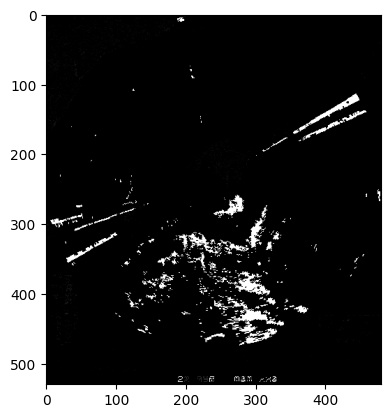

In [386]:
plt.imshow(last_img_mask, 'gray')
cv2.imwrite("clean_mask.png", last_img_mask)

In [336]:
mask_bg_o = cv2.bitwise_and(last_img_mask, cv2.bitwise_not(img_ave_mask))
# mask_bg = cv2.dilate(mask_bg, np.ones((3,3)))#cv2.morphologyEx(mask_bg, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
mask_bg = mask_bg_o.copy()
mask_bg[mask_bg < 255] = 0
mask_bg = cv2.dilate(mask_bg_o, np.ones((3,3)))
mask_bg = cv2.morphologyEx(mask_bg, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)))
mask_bg = cv2.morphologyEx(mask_bg, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS,(15,15)))
contours,hierarchy = cv2.findContours(mask_bg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    score  = 0
    
    # crit 1:
    rows,cols = out_cnt.shape[:2]
    [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    ori = math.atan2((righty - lefty),(cols-1)) * 180 / np.pi
    c1_score = abs(abs(ori) - 45)
    
    # crit 2:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    (x, y), (width, height), angle = rect
    try:
        aspect_ratio = min(width, height) / max(width, height)
    except:
        continue
    if aspect_ratio < 0.2 or (aspect_ratio < 0.4 and c1_score < 5):
        cv2.drawContours(mask_bg_o,[box],-1,(255, 0, 0), 5)

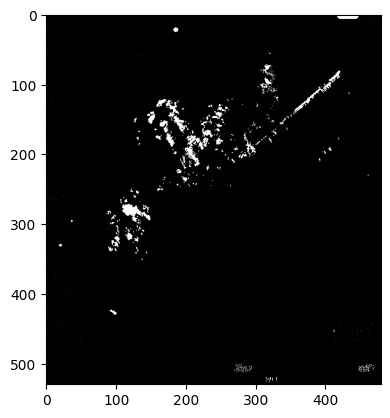

In [337]:
plt.imshow(mask_bg_o,'gray')

In [387]:
out = dataset_creator(barca, out_cnt, last_img)

True

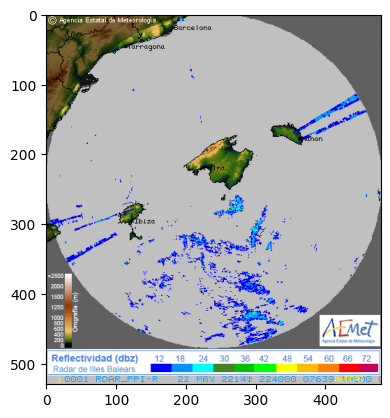

In [388]:
plt.imshow(out)
cv2.imwrite("cleaned.png", cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

True

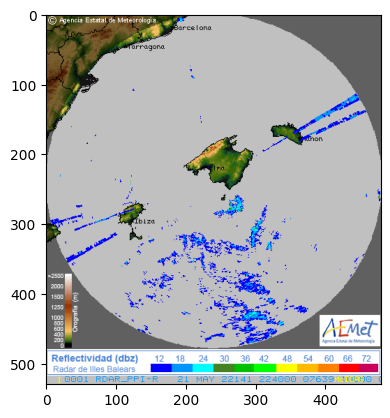

In [389]:
plt.imshow(last_img)
cv2.imwrite("input_base.png", cv2.cvtColor(last_img, cv2.COLOR_BGR2RGB))

In [353]:
cv2.imwrite("input_base.png", out)

True